# 房价预测机器学习项目（优化版）

本项目将使用机器学习算法对房价进行预测，针对计算效率进行了优化。我们将按照以下步骤进行：

1. 数据加载与探索
2. 数据预处理（优化：减少特征数量）
3. 特征工程（优化：舍弃高基数特征）
4. 模型训练与评估（优化：只使用高效算法）
5. 模型优化
6. 预测测试集房价

## 1. 数据加载与探索

In [2]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
# 只保留高效算法，移除低级算法
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# 设置图表样式
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
# 加载数据
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# 查看训练集的基本信息
print("训练集形状:", train_data.shape)
train_data.head()

训练集形状: (47439, 41)


,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,...,"Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,...,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,...,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,...,"Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA
4,4,7415 O Donovan Rd,1175000.0,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,...,NaN,NaN,NaN,2019-06-07,1595000.0,2016-06-27,900000.0,Creston,93432,CA


In [4]:
# 查看测试集的基本信息
print("测试集形状:", test_data.shape)
test_data.head()

测试集形状: (31626, 40)


,Id,Address,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,47439,3034 N Coolidge Ave,Live within steps to the scenic views on the L...,SingleFamily,2020.0,Central,Central Air,Tandem Uncovered,940.0,2,...,Tandem Uncovered,NaN,NaN,2020-11-06,799900.0,2020-07-01,819000.0,Dodgertown,90090,CA
1,47440,565 Kenilworth Ave,duplex fixer. Input for comps only,SingleFamily,1924.0,Natural Gas,NaN,Detached,10018.8,3,...,Detached,521977.0,7494.0,2014-04-04,479950.0,2020-11-03,15000.0,San Leandro,94577,CA
2,47441,3028 N Coolidge Ave,Live within steps to the scenic views on the L...,SingleFamily,2020.0,Central,Central Air,Tandem Uncovered,940.0,2,...,Tandem Uncovered,NaN,NaN,2020-11-12,839900.0,NaN,NaN,Los Angeles,90039,CA
3,47442,3022 N North Coolidge Ave,Live within steps to the scenic views on the L...,SingleFamily,2020.0,Central,Central Air,Tandem Uncovered,940.0,2,...,Tandem Uncovered,442800.0,5370.0,2020-11-06,809900.0,2020-09-21,810000.0,Dodgertown,90090,CA
4,47443,2515 Admiral Cir,"This beautiful, spacious home built in 2017 is...",SingleFamily,2017.0,Forced Air,Central Air,"Garage Door Opener, Attached",2613.6,4,...,"Garage Door Opener, Attached",965282.0,12912.0,2020-12-02,1095000.0,2019-12-27,1041000.0,Hayward,94545,CA


## 2. 数据预处理与特征工程（优化版）

In [5]:
# 设置目标变量列名
target_column = 'Sold Price'

# 合并训练集和测试集进行预处理（不包括目标变量）
# 保存训练集的目标变量
if target_column in train_data.columns:
    y_train = train_data[target_column].copy()
    features = train_data.drop(columns=[target_column])
else:
    print(f"警告: 未找到目标变量 {target_column}，请确认正确的列名")
    features = train_data.copy()
    y_train = None

# 合并特征进行预处理
all_features = pd.concat([features, test_data], axis=0)
print("合并后的特征形状:", all_features.shape)

合并后的特征形状: (79065, 40)


In [6]:
# 处理数值型特征
numeric_features = all_features.select_dtypes(include=['int64', 'float64']).columns.tolist()
# 从数值型特征中移除ID列
if 'Id' in numeric_features:
    numeric_features.remove('Id')

# 处理分类特征 - 优化：舍弃种类数量大于10的类别
categorical_features = []
high_cardinality_features = []

for col in all_features.select_dtypes(include=['object']).columns:
    n_unique = all_features[col].nunique()
    if n_unique <= 10:  # 只保留种类数量不超过10的类别
        categorical_features.append(col)
    else:
        high_cardinality_features.append(col)

print("数值型特征数量:", len(numeric_features))
print("保留的分类特征数量:", len(categorical_features))
print("舍弃的高基数特征数量:", len(high_cardinality_features))
print("舍弃的高基数特征:", high_cardinality_features)

数值型特征数量: 18
保留的分类特征数量: 1
舍弃的高基数特征数量: 20
舍弃的高基数特征: ['Address', 'Summary', 'Type', 'Heating', 'Cooling', 'Parking', 'Bedrooms', 'Region', 'Elementary School', 'Middle School', 'High School', 'Flooring', 'Heating features', 'Cooling features', 'Appliances included', 'Laundry features', 'Parking features', 'Listed On', 'Last Sold On', 'City']


In [7]:
# 创建特征处理管道
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 组合所有转换器
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
# 分离回训练集和测试集
train_rows = len(train_data)
processed_features = preprocessor.fit_transform(all_features)

# 转换为稀疏矩阵
X_train_processed = processed_features[:train_rows]
X_test_processed = processed_features[train_rows:]

print("处理后的训练特征形状:", X_train_processed.shape)
print("处理后的测试特征形状:", X_test_processed.shape)

处理后的训练特征形状: (47439, 20)
处理后的测试特征形状: (31626, 20)


## 4. 模型训练与评估（优化：只使用高效算法）

In [9]:
# 定义评估函数
def evaluate_model(model, X, y, cv=5):
    # 使用交叉验证评估模型
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-cv_scores)
    return rmse_scores.mean(), rmse_scores.std()

In [10]:
# 只使用高效算法，总算法不超过5个
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42)
}

# 评估所有模型
results = {}
for name, model in models.items():
    print(f"评估 {name}...")
    mean_rmse, std_rmse = evaluate_model(model, X_train_processed, y_train)
    results[name] = {'mean_rmse': mean_rmse, 'std_rmse': std_rmse}
    print(f"{name} - 平均RMSE: {mean_rmse:.2f}, 标准差: {std_rmse:.2f}")

# 找出最佳模型
best_model_name = min(results, key=lambda k: results[k]['mean_rmse'])
print(f"\n最佳模型: {best_model_name} 具有最低的RMSE: {results[best_model_name]['mean_rmse']:.2f}")

评估 Random Forest...
Random Forest - 平均RMSE: 747408.33, 标准差: 334262.83
评估 Gradient Boosting...
Gradient Boosting - 平均RMSE: 757300.62, 标准差: 331749.44
评估 XGBoost...
XGBoost - 平均RMSE: 889643.78, 标准差: 294392.74
评估 LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2674
[LightGBM] [Info] Number of data points in the train set: 37951, number of used features: 20
[LightGBM] [Info] Start training from score 1278660.628284
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001785 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2673
[LightGBM] [Info] Number of data points in the train set: 37951, number of used features: 20
[LightGBM] [Info] Start training from score 1271112.960871
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing w

## 5. 模型优化

In [11]:
# 对最佳模型进行超参数调优
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    }
    best_model = RandomForestRegressor(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
    best_model = GradientBoostingRegressor(random_state=42)
elif best_model_name == 'XGBoost':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    }
    best_model = xgb.XGBRegressor(random_state=42)
elif best_model_name == 'LightGBM':
    param_grid = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'num_leaves': [31, 50]
    }
    best_model = lgb.LGBMRegressor(random_state=42)

# 使用网格搜索进行超参数调优
grid_search = GridSearchCV(
    best_model, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
)

print(f"对 {best_model_name} 进行超参数调优...")
grid_search.fit(X_train_processed, y_train)

# 获取最佳参数和模型
best_params = grid_search.best_params_
optimized_model = grid_search.best_estimator_

print(f"最佳参数: {best_params}")
print(f"优化后的RMSE: {np.sqrt(-grid_search.best_score_):.2f}")

对 Random Forest 进行超参数调优...
最佳参数: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
优化后的RMSE: 823161.00


## 6. 预测测试集房价

In [12]:
# 使用优化后的模型预测测试集
test_predictions = optimized_model.predict(X_test_processed)

# 创建提交文件
submission = pd.DataFrame({
    'Id': test_data['Id'],
    'Sold Price': test_predictions
})

# 保存预测结果
submission.to_csv('house_price_predictions.csv', index=False)
print("预测完成，结果已保存到 'house_price_predictions.csv'")

预测完成，结果已保存到 'house_price_predictions.csv'


## 7. 特征重要性分析

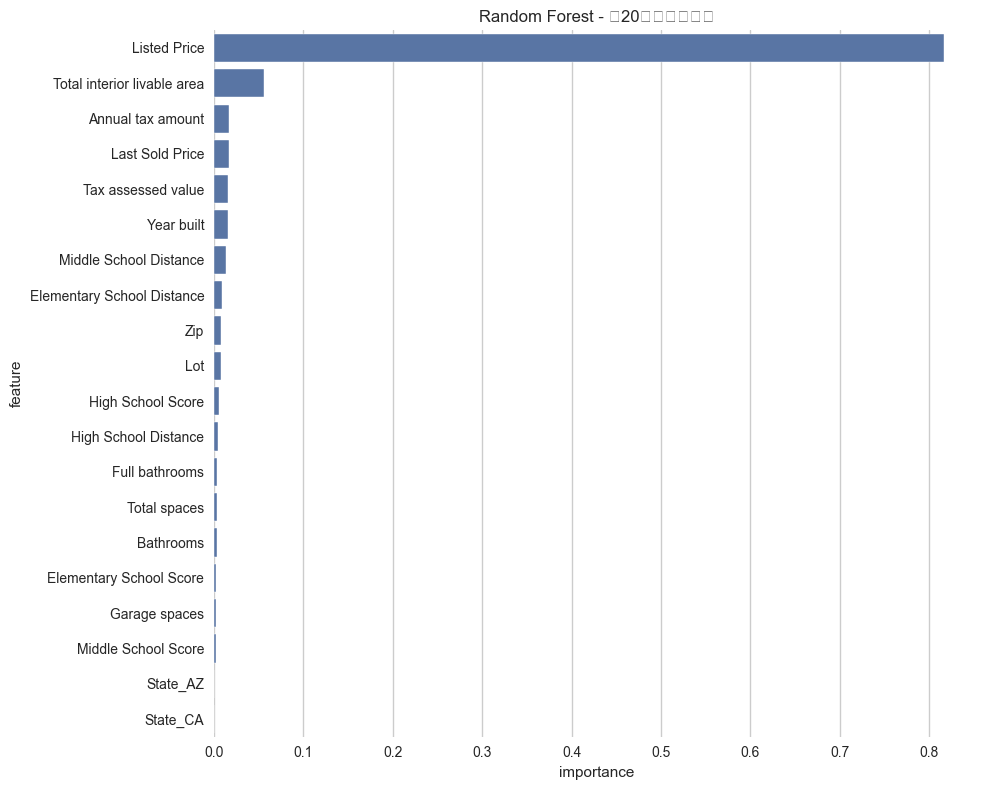

In [15]:
# 如果模型支持特征重要性，则显示前20个最重要的特征
if hasattr(optimized_model, 'feature_importances_'):
    # 获取特征名称（如果可能）
    feature_names = []
    
    # 对于数值特征，直接使用列名
    for feature in numeric_features:
        feature_names.append(feature)
    
    # 对于分类特征，尝试从OneHotEncoder获取特征名称
    try:
        ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
        for i, feature in enumerate(categorical_features):
            for category in ohe.categories_[i]:
                feature_names.append(f"{feature}_{category}")
    except:
        # 如果无法获取确切的特征名称，使用索引
        for i in range(len(feature_names), len(optimized_model.feature_importances_)):
            feature_names.append(f"feature_{i}")
    
    # 创建特征重要性DataFrame
    if len(feature_names) == len(optimized_model.feature_importances_):
        importances = pd.DataFrame({
            'feature': feature_names,
            'importance': optimized_model.feature_importances_
        })
        
        # 按重要性排序并显示前20个
        top_features = importances.sort_values('importance', ascending=False).head(20)
        
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=top_features)
        plt.title(f"{best_model_name} - 前20个最重要特征")
        plt.tight_layout()
        plt.show()
    else:
        print("无法匹配特征名称与重要性分数")
else:
    print("所选模型不支持特征重要性分析")